In [1]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil
from collections import defaultdict as dd
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

### 데이터 불러오기

Image size: (3200, 3200)
Image format: PNG
Image mode: RGBA


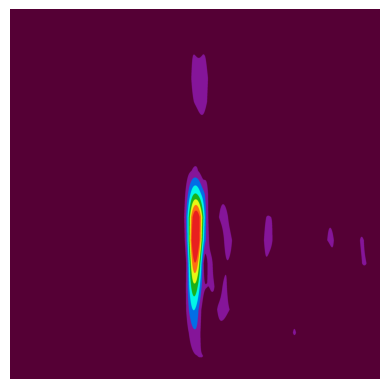

In [2]:
sample_data = "image/impact/HB5_LPMS_Impact Test/2021-04-15_14-01-28(57T0SG2)/HB5_LPMS_00001_CH11_0/V-111.png"
image = Image.open(sample_data)

# 이미지 정보 출력
print(f"Image size: {image.size}")
print(f"Image format: {image.format}")
print(f"Image mode: {image.mode}")

# 이미지 표시
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

### 폴더 복사

In [4]:
src_folder = 'image'  # 복사할 원본 폴더 경로
dst_folder = 'data'  # 복사해서 생성할 대상 폴더 경로

if os.path.exists(dst_folder): print(f"{dst_folder}가 이미 존재합니다")
else:
    print(f"{src_folder}을(를) {dst_folder}으로 복사합니다.")
    shutil.copytree(src_folder, dst_folder)

image을(를) data으로 복사합니다.


### 폴더 구조 변경

In [8]:
def rename_subfolders(root_dir):
    ret = dd(str)

    # 루트 디렉토리 탐색
    serial = 0
    for root, dirs, files in os.walk(root_dir, topdown=False):
        for name in files:
            serial += 1
            
            _, extension = os.path.splitext(name)
            old_path = os.path.join(root, name)
            ret[serial] = old_path
            new_path = os.path.join(root, str(serial)+extension)
            os.rename(old_path, new_path)
    return ret

In [9]:
# remove_subfolders("image/not_impact")
def remove_subfolders(root_dir):
    # 루트 디렉토리 탐색
    for root, dirs, files in os.walk(root_dir, topdown=False):
        for name in files:
            # 파일을 상위 디렉토리로 이동
            file_path = os.path.join(root, name)
            new_path = os.path.join(root_dir, name)
            shutil.move(file_path, new_path)

        # 빈 폴더 삭제
        for name in dirs:
            dir_path = os.path.join(root, name)
            try:
                os.rmdir(dir_path)
            except OSError as e:
                print(f"Error: {dir_path} - {e.strerror}")

In [10]:
def flatten_subfolders(root_dir):
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Data directory {root_dir} does not exist.")

    ori_name = rename_subfolders(root_dir)
    for c in glob(f"{root_dir}/**"): remove_subfolders(c)
    return ori_name

In [3]:
# 데이터 경로 설정
data_dir = "data"
# ori_name = flatten_subfolders(data_dir)

In [4]:
# 데이터 전처리 및 증강
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(), [C] 데이터 특성상 이거는 쓰면 안됨
    # transforms.RandomRotation(10), [C] 데이터 특성상 이거는 쓰면 안됨
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # pretrained weight 쓸 거면 위와 같이 정규화 하는게 좋을 듯
    # https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
])

# 데이터셋 로드
dataset = datasets.ImageFolder(data_dir, transform=transform)

### 변환된 데이터 출력

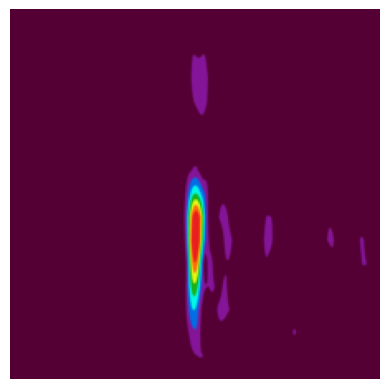

In [5]:
image, label = dataset[0]

inverse_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# 정규화된 텐서 이미지를 역정규화합니다
inverse_normalized_tensor_image = inverse_normalize(image)

# 역정규화된 텐서를 PIL 이미지로 변환
pil_image = transforms.ToPILImage()(inverse_normalized_tensor_image)

# 이미지를 Matplotlib로 표시
plt.imshow(pil_image)
plt.axis('off')  # 축 제거
plt.show()

### 데이터셋 저장

In [8]:
# 전처리된 데이터 저장
train_data = []

for image_tensor, label in dataset:
    train_data.append((image_tensor, label))

# 저장할 파일 경로
train_data_file = './train_data.pkl'

# 데이터 저장
with open(train_data_file, 'wb') as f:
    pickle.dump(train_data, f)

print(f"Train data saved to {train_data_file}")

###